# Setup

In [1]:
%matplotlib inline
#Base libraries for interactive work
import numpy as np #We will make extensive use of Numpy arrays 
import multiprocessing as mp #Enable multiprocessing
from tqdm import tqdm_notebook #For monitoring process of big jobs
from astropy.io import fits #astropy modules for FITS IO
import re #to extract trim sections for FITS header

#Libraries for angular conversion
from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import Angle

#Libraries for star catalogue lookup
from astroquery.simbad import Simbad

#Based libraries for iPython Plots
import matplotlib  #ploting
matplotlib.use("Agg")  #some hack to stop the bouncing python icon when plotting of os/x
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm #for better display of FITS images
import time as t
%matplotlib inline

#import medfit  #Fortran backend for median fits (this is much faster and reliable than the python version)

import neossatlib as neo  #Main Python Libs for NEOSSat processing. 

In [2]:
workdir='raw/'  #Directory that contains FITS files (don't forget the trailing "/")
savedir="clean/" #Directory to save cleaned images. 
#fileslist is located in 'workdir'
fileslist='files.list' #Simple text file that contains the names of all the FITS files to process.  
bpix=-1.0e10                   #value to mark bad pixels. Any pixel *below* bpix is considered invalid.
sigscalel=1.0                  #low bounds for display clipping.  Keep small to keep background 'dark'
sigscaleh=1.0                  #high bounds for display clipping.
nprocessor=8                   #Number of processors to use for data processing. 
#--- Parameters for making a Dark image ---#
ilow=1                         #number of low value frames to reject when generating dark image
ihigh=1                        #number of high value frames to reject when generating dark image
#--- Parameters for Fourier Decomp. ---#
snrcut=10.0  #When to stop decomposition 
fmax=2 #Maximum number of frequencies in model
xoff=0 #pixel offsets 
yoff=0
T=8 #Oversampling for FFT calculations to better estimate frequency of electronic interference.  
info=0 # 0 - no plots, no output, 1 - no plots, output, 2 - plots, output

imagefiles=neo.read_file_list(workdir+fileslist)

In [3]:
#Use the first image to set dimensions for processing.
i=0 #index of first image.  
filename=workdir+imagefiles[i]
trim,btrim,xsc,ysc,xov,yov=neo.getimage_dim(filename)

In [4]:
lightlist=[]
jddate=[]
exptime=[]
nfiles=len(imagefiles)
for i in range(nfiles):
    filename=workdir+imagefiles[i]
    hdulist = fits.open(filename)
    shutter=hdulist[0].header['SHUTTER']
    mode=hdulist[0].header['MODE']
    # Mode=16 => Fine point.  Mode=13 => Fine Slew
    if (int(shutter[0]) == 0) & ( (int(mode[0:2]) == 16) or (int(mode[0:2]) == 13) ):  #Check if shutter was open or closed.
        lightlist.append(imagefiles[i])
        jddate.append(float(hdulist[0].header['JD-OBS']))
        exptime.append(float(hdulist[0].header['EXPOSURE']))
    hdulist.close()
jddate=np.array(jddate)
exptime=np.array(exptime)
print("number of images: ",len(lightlist))

number of images:  289


SHUTTER:  0 (open)
MODE:  16 - FINE_POINT
RA:  295.435
DEC:  39.880833333333335
ROL:  157.70062
raw/./K1625/NEOS_SCI_2019147052435.fits


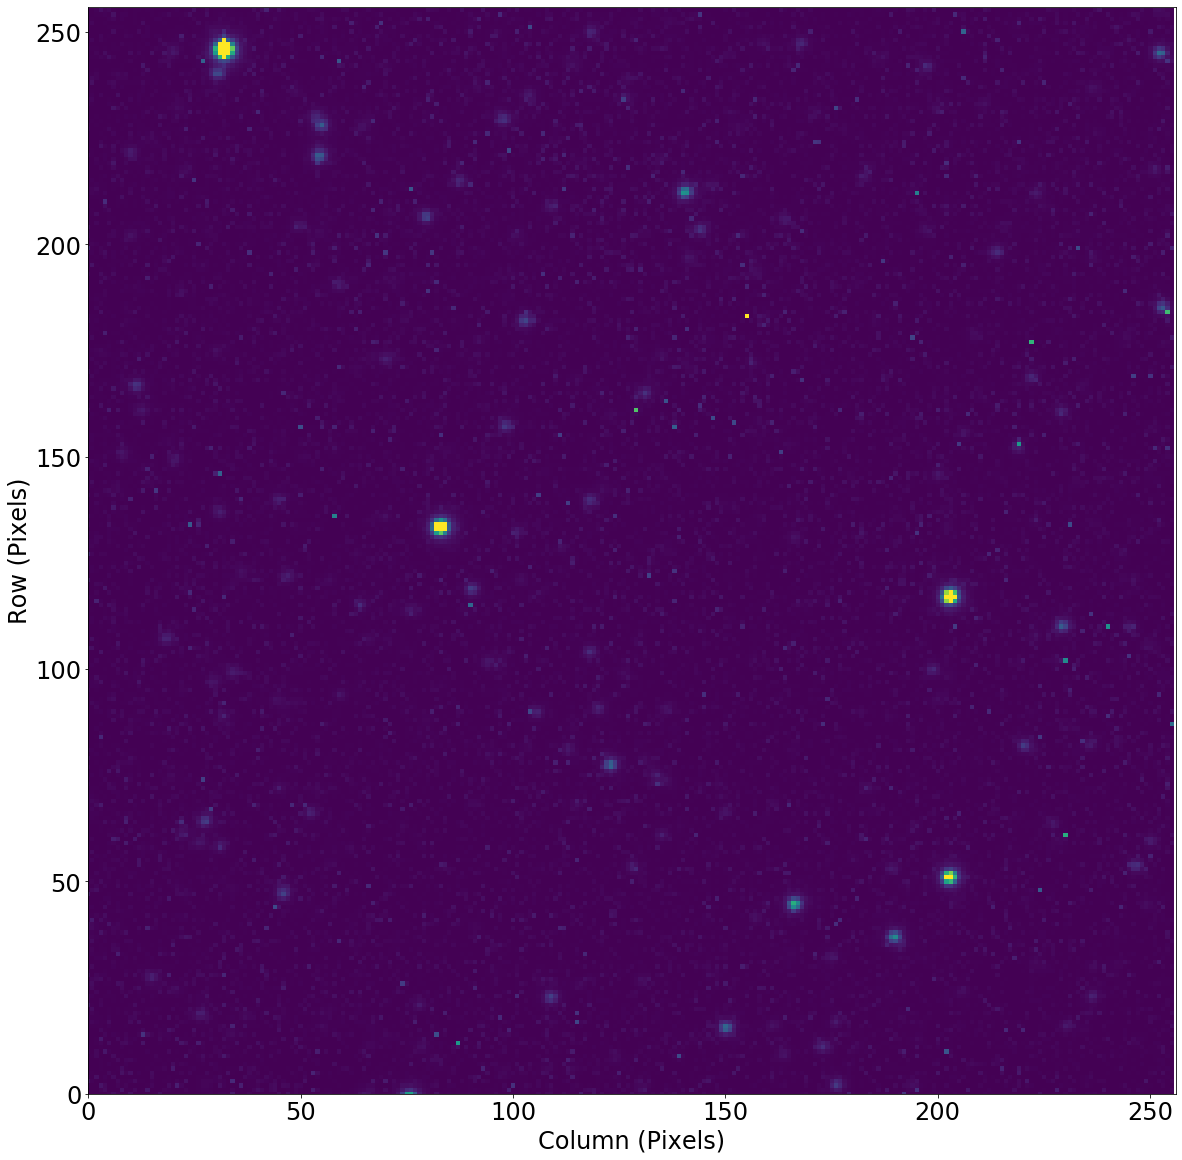

In [5]:
filename=workdir+lightlist[10]  #pick an image somewhere around the middle.

#Grab metadata
hdulist=fits.open(filename)
shutter=hdulist[0].header['SHUTTER']
mode=hdulist[0].header['MODE']
ra=hdulist[0].header['OBJCTRA']
dec=hdulist[0].header['OBJCTDEC']
rol=hdulist[0].header['OBJCTROL']

#Convert rotation to decimal degrees
ra=Angle(ra+' hours').degree
dec=Angle(dec+' degrees').degree
rol=float(rol)

print('SHUTTER: ', shutter)
print('MODE: ', mode)
print('RA: ', ra)
print('DEC: ', dec)
print('ROL: ', rol)
print(filename)
scidata=neo.read_fitsdata(filename)

pixsize = 0.86/1024     #Size of one pixel, in degrees
imhalfdiag = np.linalg.norm([xsc, ysc]) * pixsize   #Half diagonal length of image, in degrees
    
sh=scidata.shape
strim=np.array([sh[0]-xsc,sh[0],sh[1]-ysc,sh[1]])
scidata_c=np.copy(scidata[strim[0]:strim[1],strim[2]:strim[3]])
imstat=neo.imagestat(scidata_c,bpix)
matplotlib.rcParams.update({'font.size': 24}) #adjust font
plt.figure(figsize=(20,20)) #adjust size of figure
flat=scidata_c.flatten()
imgplot = plt.imshow(scidata_c[:,:]-imstat[0])

plt.axis((0,scidata_c.shape[1],0,scidata_c.shape[0]))
plt.xlabel("Column (Pixels)")
plt.ylabel("Row (Pixels)")
plt.show()

# SIMBAD request and plotting random stars

In [6]:
#Request data for this region
loc = coord.SkyCoord(ra, dec, unit=(u.degree, u.degree), frame='icrs')
result_table = Simbad.query_region(loc, radius=imhalfdiag * u.deg)
objlist = []
#Collate data for this region
for i, obj_info in enumerate(result_table):
    obj = [None, None, None]
    obj[0] = result_table['MAIN_ID'][i].decode('ASCII')
    obj[1] = float(Angle(result_table['RA'][i]+' hours').degree)
    obj[2] = float(Angle(result_table['DEC'][i]+' degrees').degree)
    objlist.append(obj)

len(objlist)

1602

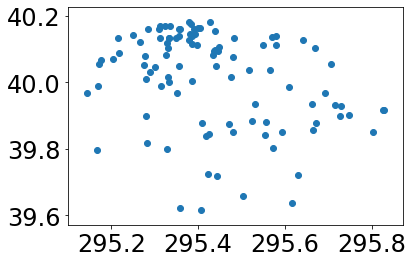

In [9]:
names = np.array(objlist)[:, 0]
coords = np.array(objlist)[:, 1:].astype(float)

select = np.random.choice(names.shape[0], 100, replace=False)
names_trunc = names[select]
coords_trunc = coords[select, :]
plt.scatter(coords_trunc[:, 0], coords_trunc[:, 1])

In [45]:
objlist_trunc[:, 1]

array(['295.17314791666666', '295.52562916666665', '295.2680066666666',
       '295.4848183333333', '295.16598416666665', '295.37752958333334',
       '295.56661499999996', '295.2316358333333', '295.6408233333333',
       '295.1492083333333', '295.4344670833333', '295.2973070833333',
       '295.53076583333325', '295.36734375', '295.2059120833333',
       '295.4069275', '295.2950125', '295.39826999999997',
       '295.6258333333333', '295.1621675', '295.39055583333334',
       '295.63209374999997', '295.2731191666667', '295.41589749999997',
       '295.11100625', '295.31483541666665', '295.4598654166666',
       '295.69035291666665', '295.4328591666667', '295.37923624999996',
       '295.6190208333333', '295.6429383333333', '295.5364716666666',
       '295.2375525', '295.5436179166666', '295.43762458333333',
       '295.26290624999996', '295.35934208333333', '295.43924333333325',
       '295.47383874999997', '295.47388333333333', '295.37658958333327',
       '295.7327504166666', '295.4